In [3]:
# 1. 导入依赖
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
plt.rcParams['font.sans-serif'] = ['STHeiti', 'SimHei', 'Microsoft YaHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt

# 让图像内嵌在 notebook 里显示
%matplotlib inline

In [4]:
# 2. 读取月度特征数据
monthly_path = "data/sh000016_monthly_features.csv"  # 如果路径不同，在这里改
df_month = pd.read_csv(monthly_path)


df_month["month"] = pd.to_datetime(df_month["month"])
df_month["month"] = df_month["month"].dt.to_period("M").dt.to_timestamp()
df_month.head()

,month,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str
0,2015-01-01,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01
1,2015-02-01,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02
2,2015-03-01,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03
3,2015-04-01,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04
4,2015-05-01,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05


In [5]:
# 3. 处理日期列并设为索引
date_col = "month"   # 如果你的列叫 'month' 就改成 "month"
df_month[date_col] = pd.to_datetime(df_month[date_col])
df_month = df_month.sort_values(date_col).set_index(date_col)

df_month.head()


,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str
month,,,,,,,
2015-01-01,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01
2015-02-01,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02
2015-03-01,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03
2015-04-01,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04
2015-05-01,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05


In [6]:
# 3. 指定用于 Regime 聚类的特征列
feature_cols = [
    "ret_month",
    "vol_month_sum",
    "vol_20_annual_month_end"
]

# 检查列是否存在
missing = [c for c in feature_cols if c not in df_month.columns]
if missing:
    print("缺失列：", missing)
else:
    print("聚类特征列：", feature_cols)

# 4. 取出特征矩阵并标准化
X_raw = df_month[feature_cols].copy().dropna()
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

X.shape


聚类特征列： ['ret_month', 'vol_month_sum', 'vol_20_annual_month_end']


(120, 3)

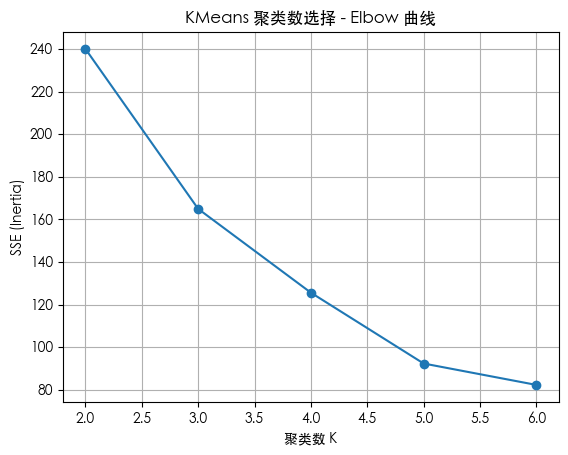

In [7]:
# 5. Elbow 曲线 (SSE)
sse = []
K_range = range(2, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    sse.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), sse, marker="o")
plt.xlabel("聚类数 K")
plt.ylabel("SSE (Inertia)")
plt.title("KMeans 聚类数选择 - Elbow 曲线")
plt.grid(True)
plt.show()


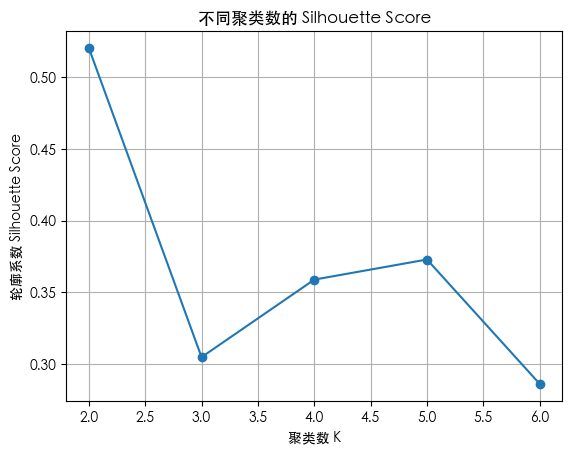

[(2, np.float64(0.5203540742408097)),
 (3, np.float64(0.304812888705872)),
 (4, np.float64(0.3588605817272719)),
 (5, np.float64(0.3728757902352798)),
 (6, np.float64(0.2861553907304862))]

In [8]:
# 6. Silhouette Score
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure()
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("聚类数 K")
plt.ylabel("轮廓系数 Silhouette Score")
plt.title("不同聚类数的 Silhouette Score")
plt.grid(True)
plt.show()

list(zip(K_range, sil_scores))


In [9]:
# 7. KMeans 聚类
K = 3  # 如果你觉得 4 更好，就改成 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X)

df_cluster = df_month.loc[X_raw.index].copy()
df_cluster["cluster"] = cluster_labels

df_cluster.head()


,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str,cluster
month,,,,,,,,
2015-01-01,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01,2
2015-02-01,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02,0
2015-03-01,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03,2
2015-04-01,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04,2
2015-05-01,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05,2


In [10]:
# 8. 不同 cluster 的特征均值（很重要）
cluster_profile = df_cluster.groupby("cluster")[feature_cols].mean()
cluster_profile


,ret_month,vol_month_sum,vol_20_annual_month_end
cluster,,,
0,0.052686,7.565731e+10,0.175145
1,-0.030444,6.459630e+10,0.178653
2,-0.019967,2.975105e+11,0.453852


In [11]:
# 9. 根据 cluster_profile 的结果手动映射 Regime 名称
cluster_to_regime = {
    0: "Regime_Bull",      # 比如 0 类：上涨+低波动
    1: "Regime_Bear",      # 比如 1 类：下跌+高波动
    2: "Regime_Sideways",  # 比如 2 类：震荡
}

df_cluster["regime"] = df_cluster["cluster"].map(cluster_to_regime)

df_cluster[["cluster", "regime"]].head()


,cluster,regime
month,,
2015-01-01,2,Regime_Sideways
2015-02-01,0,Regime_Bull
2015-03-01,2,Regime_Sideways
2015-04-01,2,Regime_Sideways
2015-05-01,2,Regime_Sideways


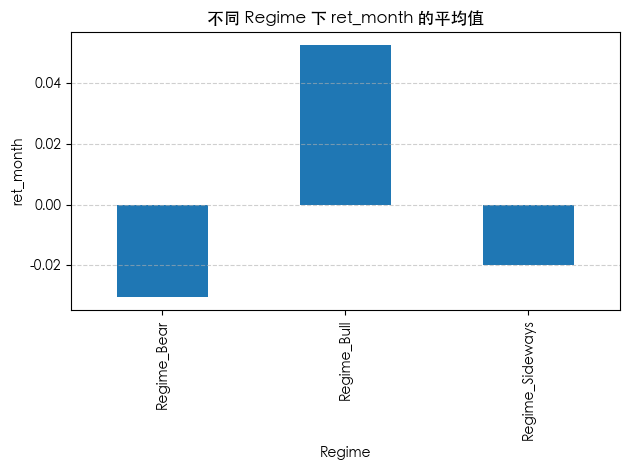

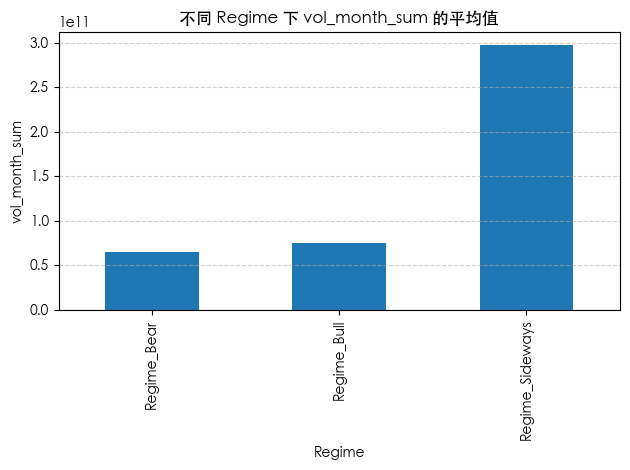

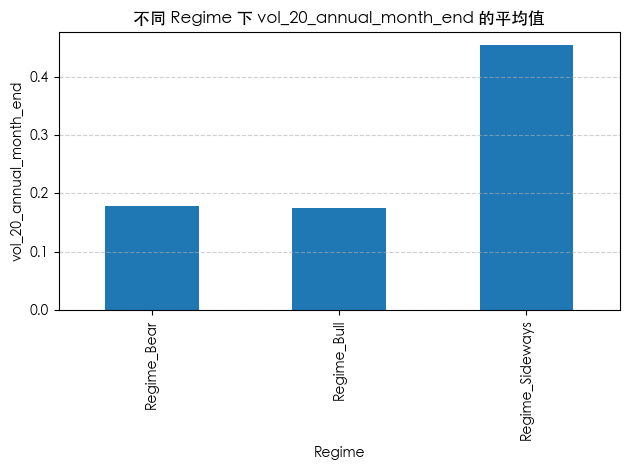

In [12]:
# 10. Regime 画像（每个特征一个柱状图）
regime_profile = df_cluster.groupby("regime")[feature_cols].mean()

for col in feature_cols:
    plt.figure()
    regime_profile[col].plot(kind="bar")
    plt.title(f"不同 Regime 下 {col} 的平均值")
    plt.xlabel("Regime")
    plt.ylabel(col)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


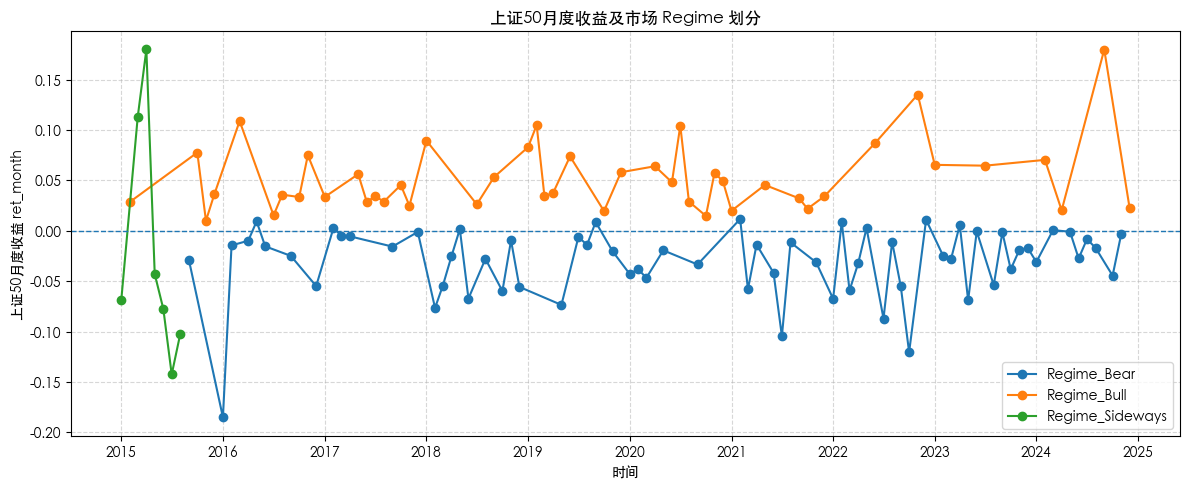

In [13]:
# 11. 在时间轴上按 Regime 着色显示月度收益
plt.figure(figsize=(12, 5))

for regime_name, sub_df in df_cluster.groupby("regime"):
    plt.plot(sub_df.index, sub_df["ret_month"], marker="o", linestyle="-", label=regime_name)

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("时间")
plt.ylabel("上证50月度收益 ret_month")
plt.title("上证50月度收益及市场 Regime 划分")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


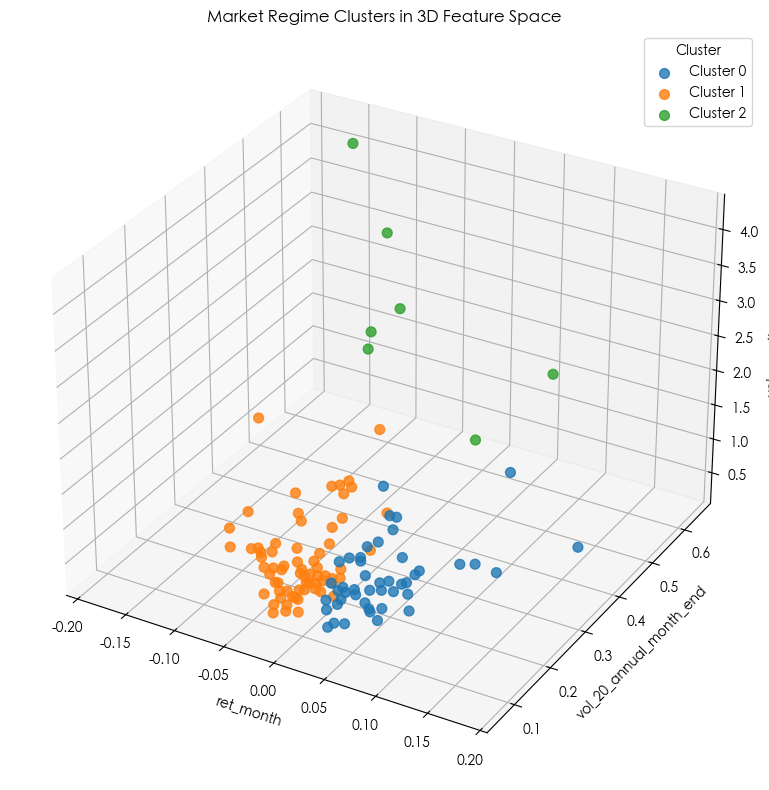

In [14]:
from mpl_toolkits.mplot3d import Axes3D  # 仅为激活 3D 支持
import matplotlib.pyplot as plt

# 选择要画的三个维度
x_col = "ret_month"
y_col = "vol_20_annual_month_end"
z_col = "vol_month_sum"

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for c, sub in df_cluster.groupby("cluster"):
    ax.scatter(
        sub[x_col],
        sub[y_col],
        sub[z_col],
        s=50,
        label=f"Cluster {c}",
        alpha=0.8,
    )

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("Market Regime Clusters in 3D Feature Space")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()


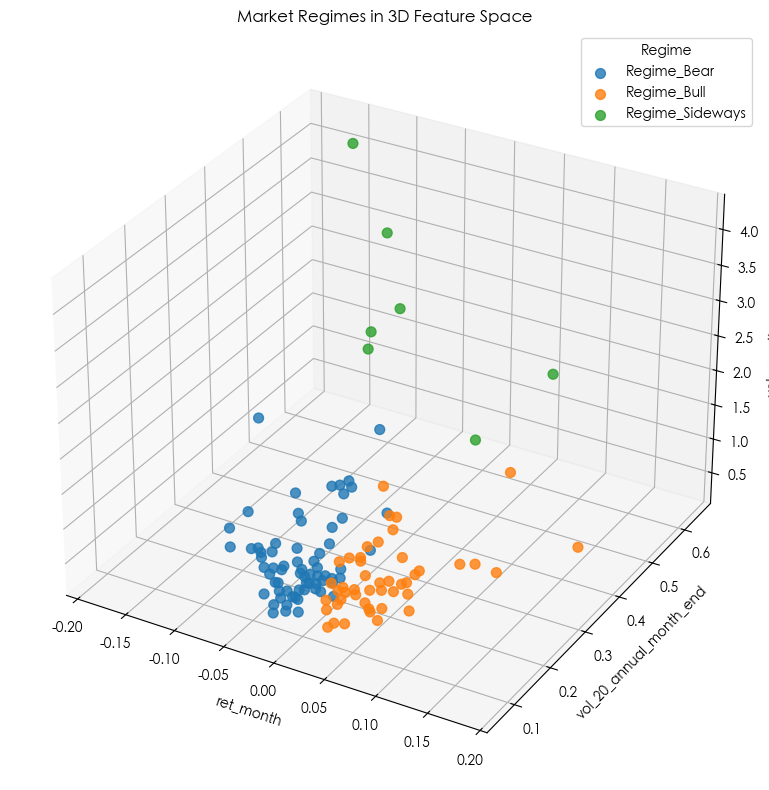

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for r, sub in df_cluster.groupby("regime"):
    ax.scatter(
        sub[x_col],
        sub[y_col],
        sub[z_col],
        s=50,
        label=r,
        alpha=0.8,
    )

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("Market Regimes in 3D Feature Space")
ax.legend(title="Regime")
plt.tight_layout()
plt.show()


In [16]:
df_cluster.head()

,close_month_end,ret_month,vol_month_sum,vol_month_chg,vol_20_annual_month_end,vol_60_annual_month_end,month_str,cluster,regime
month,,,,,,,,,
2015-01-01,2405.38,-0.068249,240759567500,-0.372974,0.467613,0.425187,2015-01,2,Regime_Sideways
2015-02-01,2474.59,0.028773,113685256600,-0.527806,0.256287,0.432385,2015-02,0,Regime_Bull
2015-03-01,2754.66,0.113178,257993309000,1.269365,0.253355,0.347897,2015-03,2,Regime_Sideways
2015-04-01,3250.49,0.179997,368238254400,0.427317,0.269143,0.270690,2015-04,2,Regime_Sideways
2015-05-01,3111.33,-0.042812,259537919800,-0.295190,0.391430,0.314535,2015-05,2,Regime_Sideways


In [17]:
df_cluster.to_csv("data/cluster_info")

In [18]:
import pandas as pd

# 读取两个文件
df_factor = pd.read_csv("data/factor_longshort.csv")
df_cluster = pd.read_csv("data/cluster_info")

# 1. 处理日期格式
df_factor["日期"] = pd.to_datetime(df_factor["日期"])
df_cluster["month"] = pd.to_datetime(df_cluster["month"])

# 2. 为了 merge 统一字段名，把 df_factor 的“日期”重命名成 month
df_factor = df_factor.rename(columns={"日期": "month"})

# 3. 合并因子收益 + regime 信息
df_merged = pd.merge(
    df_factor,
    df_cluster[["month", "regime", "cluster"]],
    on="month",
    how="left"
)

# 4. 查看结果
df_merged.head(), df_merged.tail(), df_merged["regime"].value_counts()


(       month  MOM20  MOM120   RSI     PB    PE   DIV   ROE  PROFIT_GR   VOL  \
 0 2015-01-01   0.00    0.00  0.00   0.00  0.00  0.00  0.00       0.00  0.00   
 1 2015-02-01  -4.22   -4.22 -7.76  -4.65 -7.35 -4.72 -8.90       1.88  3.05   
 2 2015-03-01   1.84    1.84  3.44  -2.68 -4.02 -6.98 -0.27       9.71 -5.85   
 3 2015-04-01  -7.83   -7.83 -3.86   2.96 -5.44 -2.13 -9.53      -7.40  8.35   
 4 2015-05-01  -9.61   -9.61 -2.20 -10.82 -8.75 -8.05 -1.88      -6.20 -1.89   
 
    BETA           regime  cluster  
 0  0.00  Regime_Sideways        2  
 1  2.06      Regime_Bull        0  
 2 -0.30  Regime_Sideways        2  
 3  1.45  Regime_Sideways        2  
 4  8.29  Regime_Sideways        2  ,
          month  MOM20  MOM120   RSI     PB     PE    DIV    ROE  PROFIT_GR  \
 115 2024-08-01  -2.42   -2.42 -0.85  -0.32   2.82   7.71   2.65      -3.12   
 116 2024-09-01  -5.67   -5.67  6.73 -10.52 -13.61  -8.65   0.66       0.34   
 117 2024-10-01   4.76    4.76  1.72  -1.96 -13.81 -12.00 

In [19]:
df_merged.head()

,month,MOM20,MOM120,RSI,PB,PE,DIV,ROE,PROFIT_GR,VOL,BETA,regime,cluster
0,2015-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Regime_Sideways,2
1,2015-02-01,-4.22,-4.22,-7.76,-4.65,-7.35,-4.72,-8.90,1.88,3.05,2.06,Regime_Bull,0
2,2015-03-01,1.84,1.84,3.44,-2.68,-4.02,-6.98,-0.27,9.71,-5.85,-0.30,Regime_Sideways,2
3,2015-04-01,-7.83,-7.83,-3.86,2.96,-5.44,-2.13,-9.53,-7.40,8.35,1.45,Regime_Sideways,2
4,2015-05-01,-9.61,-9.61,-2.20,-10.82,-8.75,-8.05,-1.88,-6.20,-1.89,8.29,Regime_Sideways,2


In [20]:
df_merged.to_csv("data/final_factor_longshort.csv")

In [22]:
!jupyter nbconvert --to webpdf --allow-chromium-download "cluster.ipynb"

[NbConvertApp] Converting notebook cluster.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 822682 bytes to cluster.pdf
